In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt 
%matplotlib inline



import os

import json

import itertools

from pickle import load,dump



In [2]:
#get the name of the subfolders containing the frames and the (x,y) coordinates 
subfolders = [ f.path for f in os.scandir('./jk_data_only_22') if f.is_dir() ]

In [3]:
#mapping class name to an integer
class_labels = {}

class_labels['correct'] = 0
class_labels['incorrect_chin_tuck'] = 1
class_labels['incorrect_lean_fwd'] = 2
class_labels['incorrect_feet_close'] = 3
class_labels['incorrect_not_low'] = 4
class_labels['incorrect_out_knees'] = 5


In [4]:
#mapping the name of the folder to the beginning of the filename(each folder has different file beginnings)
folder_to_filename = {}


folder_to_filename['a'] = 'DSC_0808_'
folder_to_filename['ax'] = 'DSC_0801_'

folder_to_filename['J_01'] = 'JVID2_'
folder_to_filename['J_02'] = 'DSC_0704_'
folder_to_filename['J_03'] = 'DSC_0703_'
folder_to_filename['J_04'] = 'DSC_0702_'
folder_to_filename['J_05'] = 'D4_'
folder_to_filename['J_06'] = 'DSC_0707_'
folder_to_filename['J_07'] = 'DSC_0701_'
folder_to_filename['J_08'] = 'DSC_0734_'
folder_to_filename['J_09'] = 'DSC_0810_'

folder_to_filename['l'] = 'DSC_0809_'
folder_to_filename['n'] = 'DSC_0806_'
folder_to_filename['r'] = 'DSC_0807_'
folder_to_filename['ry'] = 'DSC_0805_'
folder_to_filename['t'] = 'DSC_0804_'

folder_to_filename['S_01'] = 'DSC_0811_'
folder_to_filename['S_02'] = 'DSC_0705_'
folder_to_filename['S_03'] = 'DSC_0735_'

folder_to_filename['W_01'] = 'DSC_0802_'
folder_to_filename['W_02'] = 'DSC_0803_'




In [5]:
print(subfolders)
video_path = subfolders[0]
data_path = subfolders[1]

['./jk_data_only_22/video_details', './jk_data_only_22/openposedata']


In [6]:
video_files = os.listdir(video_path)
video_files.sort()

In [7]:
print(video_files)

['J_01.json', 'J_02.json', 'J_03.json', 'J_04.json', 'J_05.json', 'J_06.json', 'J_07.json', 'J_08.json', 'J_09.json', 'S_01.json', 'S_02.json', 'S_03.json', 'W_01.json', 'W_02.json', 'a.json', 'ax.json', 'l.json', 'n.json', 'r.json', 'ry.json', 't.json']


## Create the structure containing the JSONs(start frame, end frame, label for each pair) of each openpose folder

In [8]:

start_end_frames=[]

for i in range(0,len(video_files)):
       with open(video_path+'/'+video_files[i], 'r') as j:
            
            contents = json.load(j)
            start_end_frames.append(contents)

### Checking that each JSON contains an even number of values(since they are start-end frame pairs)

In [9]:
for i in range(len(video_files)):
    print(len(start_end_frames[i]['squats'][0]['in_and_out']) % 2 == 0)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [10]:
def convert_to_frame_no(frame):
    
    size = 1
    tmp = frame
    
    while tmp >=10:
        
        tmp = tmp/10
        size+=1
        
    leads=''
    
    for i in range(12-size):
        
        leads+='0'
    
    return leads + str(frame) + "_keypoints.json"
    

## Trying to read from the openpose folder

In [11]:
os.listdir(data_path)

['t',
 'l',
 'ry',
 'a',
 'J_07',
 'J_05',
 'W_02',
 'J_06',
 'S_01',
 'J_08',
 'S_03',
 'W_01',
 'J_09',
 'ax',
 'r',
 'J_02',
 'S_02',
 'n',
 'J_01',
 'J_04',
 'J_03']

In [12]:

#But when two people are in frame,both have same number of (x,y) coordinates, but some end files have just
#one person in frame, how to choose which one to use??(no depth information)
def most_keypoints(data):
    
    l0 = data['people'][0]['pose_keypoints']
    l1 = data['people'][1]['pose_keypoints']
    
    if len(l0) >= len(l1):
        return 0
    
    else:
        return 1

In [13]:
y=[]
X=[]




In [14]:
for i in range(len(video_files)):
    #get the name of the folder in the openposedata(e.g. a, J_01 etc.)
    folder = video_files[i].split('.')[0]
    
    labels = start_end_frames[i]['squats'][0]['class_label']
    #In and out frames for the current folder
    start_end = start_end_frames[i]['squats'][0]['in_and_out']
    
    converted_labels = [class_labels[label] for label in labels]
    y = y+converted_labels
    
    file_name = folder_to_filename[folder]
    path = data_path + '/' + folder + '/' + file_name
    
    for frame in range(0,len(start_end),2):
        #get start and end frame for each squat
        start_frame = start_end[frame]
        end_frame = start_end[frame+1]
        
        frames_sequence=[]
        #iterate through all the frames in between, open each json and add the list of (x,y) coordinates to the 
        #frames_sequence list
        for sequence in range(start_frame,end_frame+1):
            
            frame_number_json = convert_to_frame_no(sequence)
            
            with open(path + frame_number_json, 'r') as j:
        
                json_data = json.load(j)
                pos = 0
                
                if len(json_data['people']) > 1: 
                    
                    pos = most_keypoints(json_data)
                    
                points_with_confidence = json_data['people'][pos]['pose_keypoints']
                #remove the confidence values
                keypoints = [(points_with_confidence[k],points_with_confidence[k+1]) for k in range(0,len(points_with_confidence)-2,3)]
                
                keypoints = list(itertools.chain(*keypoints))
                
                frames_sequence.append(keypoints)
        
        
        X.append(frames_sequence)
                
                
                
                
                

            
        

In [15]:
X = np.array(X)
y = np.array(y)

<ipython-input-15-6c4156275ea8>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


In [16]:
#check the number of datapoints per class
p = list(y)
for i in range(0,6):
    print(i," count is ", p.count(i))

0  count is  70
1  count is  57
2  count is  55
3  count is  55
4  count is  54
5  count is  5


In [17]:
def interpolate_frames(frame_seq, num_frames):
    
    initial_frame_no = len(frame_seq)
    
    #this will be returned after interpolation
    interpolated_squat = np.zeros((num_frames,36))
    ##18 (x,y) pairs
    for i in range(18):
        #first, interpolate the X coordinate
        
        x = np.arange(initial_frame_no)
        y = frame_seq[:, i*2]
        f = interp1d(x, y, kind = 'cubic')
        
        x_new = np.linspace(0, initial_frame_no-1, num_frames)
        y_new = f(x_new)
        interpolated_squat[:, i*2] = y_new
        
        #interpolate Y
        
        y = frame_seq[:, i*2 + 1]
        
        f = interp1d(x, y, kind = 'cubic')
        y_new = f(x_new)
        interpolated_squat[:, i*2 + 1] = y_new
    
    
    return interpolated_squat


    
    

In [18]:
tmp = []

In [19]:
#TODO:

#Iterate through the current data structure containing the squats

#Get each squats(i.e. the sequence of frames)

#Convert to np array

#Apply the interpolate_frames function

#Flatten 

#Save it in a new np array

interpolated_frames = []

for i in range(0,len(X)):
    
    squat = np.array(X[i])
    interpolated_squat = interpolate_frames(squat,100)
    
    
    tmp.append(interpolated_squat)
    interpolated_squat = interpolated_squat.flatten()
    interpolated_frames.append(interpolated_squat)

In [20]:
interpolated_frames = np.array(interpolated_frames)

interpolated_frames.shape

(296, 3600)

In [21]:
with open('interp_frames','wb') as file:
    dump(interpolated_frames,file)

## PCA

In [22]:
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler


In [23]:
interpolated_frames.shape

(296, 3600)

In [24]:
pca = PCA(n_components = 40)
pca.fit(interpolated_frames)


PCA(n_components=40)

Text(0, 0.5, 'Explained variance')

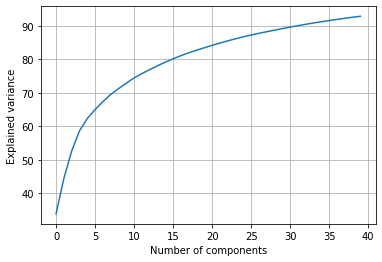

In [25]:
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

In [26]:
X_t = pca.transform(interpolated_frames)
X_t.shape


(296, 40)

In [27]:
print(len(interpolated_frames[0]))

3600


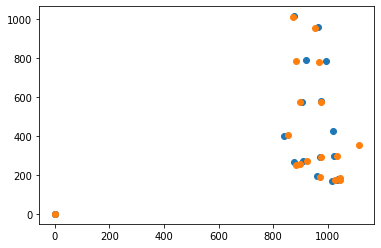

In [28]:
person = interpolated_frames[0]

xs =[]
ys = []
for i in range(0,len(person)-1,2):
    xs = xs+[person[i]]
    ys = ys + [person[i+1]]


plt.scatter(xs[:18],ys[:18])

plt.scatter(xs[1692:1710],ys[1692:1710])


18


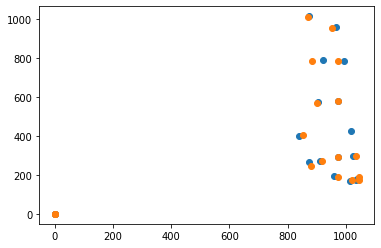

In [67]:
orig_person = X[0]

xso = []
yso = []

xs55 = []
ys55 = []

for i in range(0,18):
    xso = xso + [orig_person[0][2*i]]
    yso = yso + [orig_person[0][2*i+1]]
    
    xs55 = xs55 + [orig_person[55][2*i]]
    ys55 = ys55 + [orig_person[55][2*i+1]]
    
plt.scatter(xso,yso)
plt.scatter(xs55,ys55)
print(len(xso))

### Dataset needs to be shuffled before applying any ML models to it!

# Observations made so far:

### Start and end frames each have 36 key_points total (which means 18 (x,y) pairs)
### Some start frames have two people in them
### Although some start frames have two people in them, some end frames end with just a person in frame
### One of the files had a missing comma, which had to be added i.o.t. carry on reading the JSON
### Incredibly few labelled points(only 296) --> SMOTE(Synthetic Minority Oversampling Technique), ADASYN(Adaptive Synthetic Sampling Approach )
### Another reason for which the number of points is problematic --> the number of dimensions is 36 * number of frames per label, so curse of dimensionality(PCA is a must)
### Different number of frames per squat --> interpolation
### Over the 296 datapoints, the number of points belonging to class 5 (incorrect_out_knees) is incredibly small, will definitely lead to biases



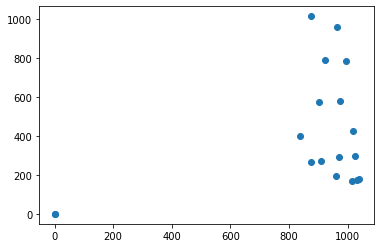

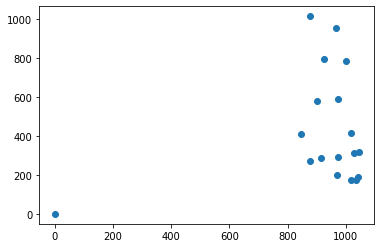

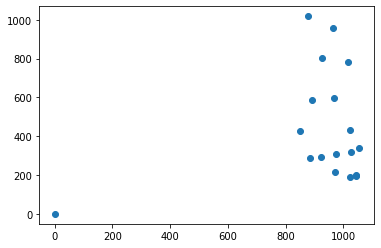

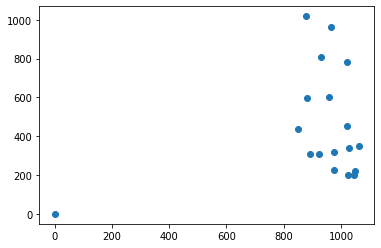

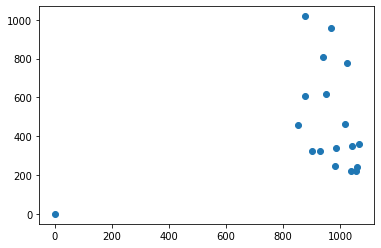

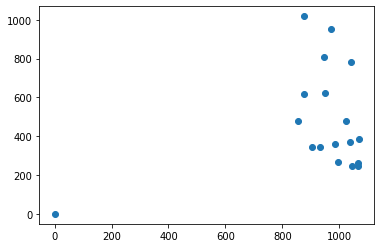

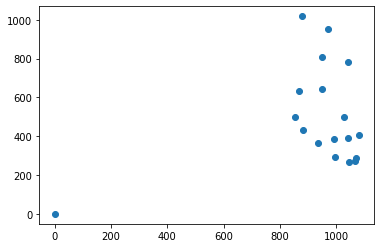

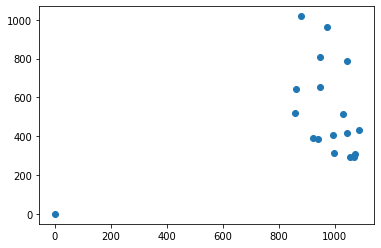

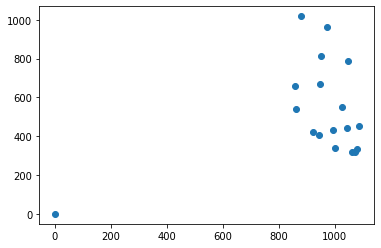

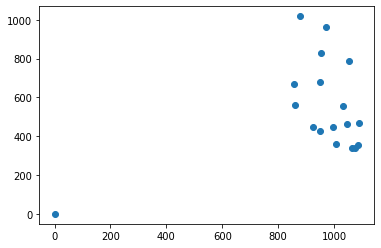

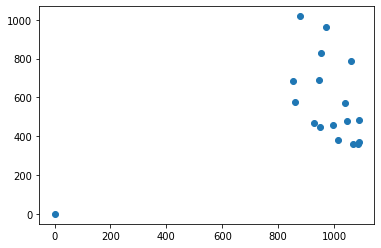

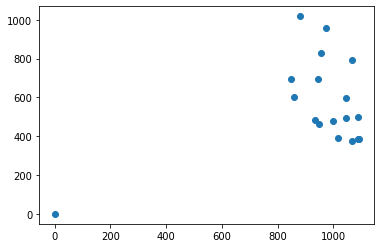

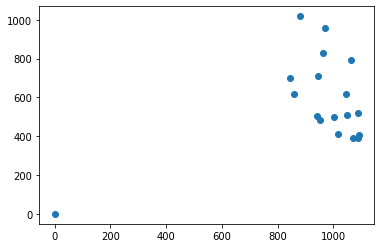

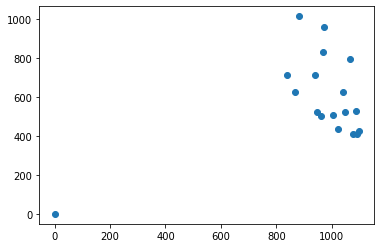

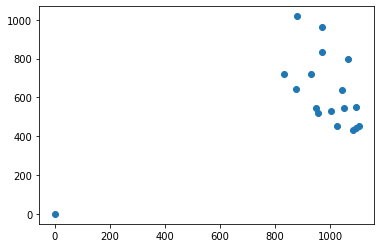

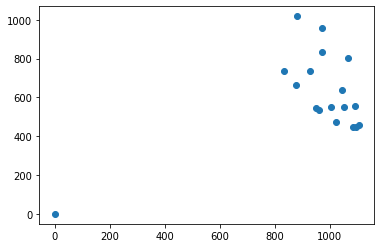

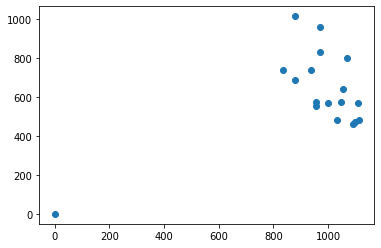

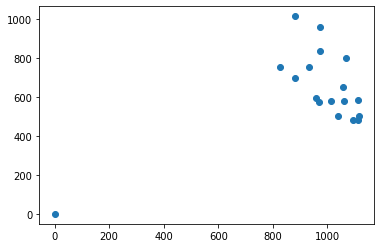

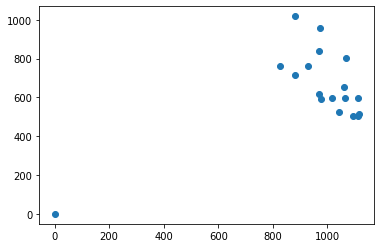

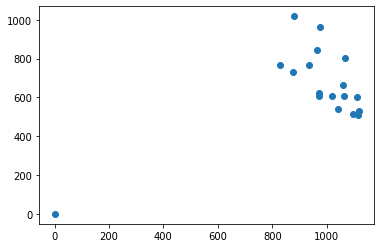

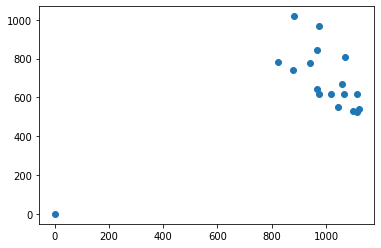

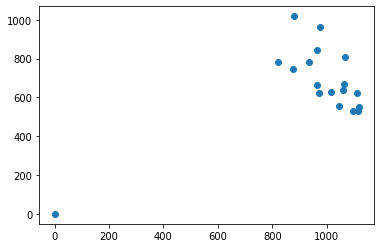

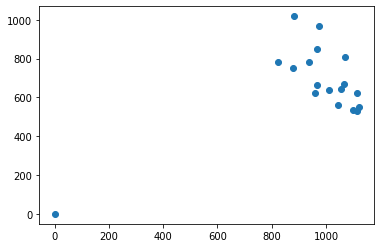

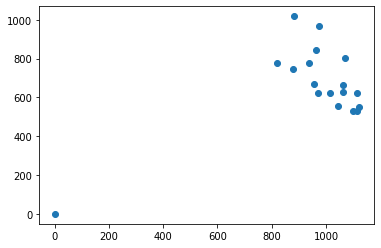

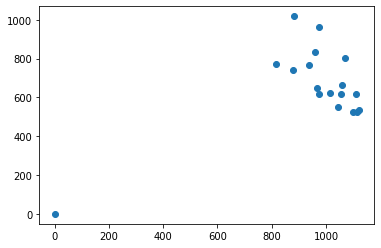

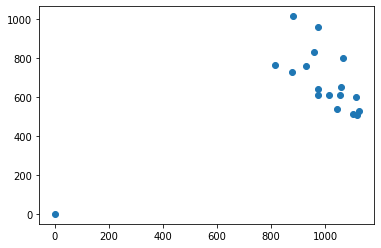

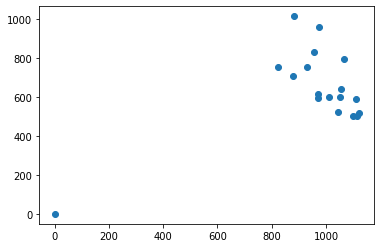

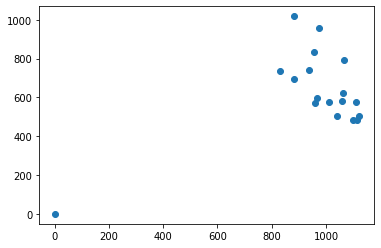

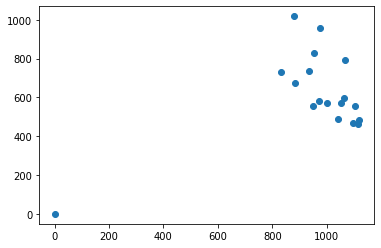

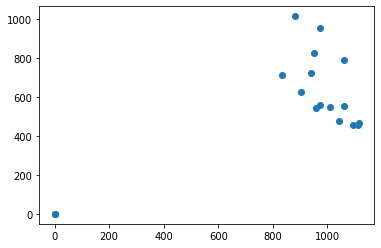

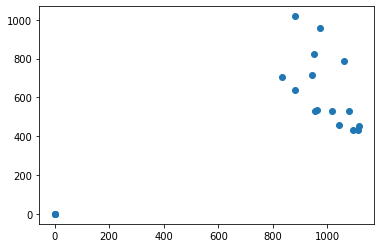

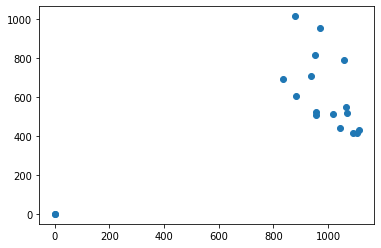

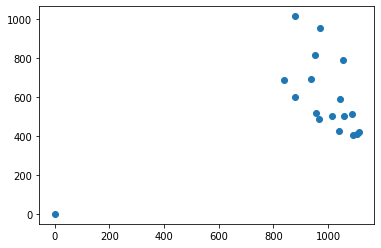

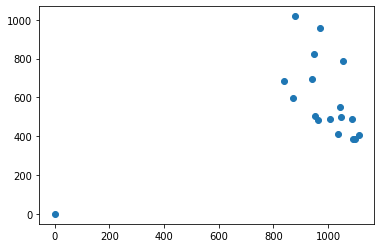

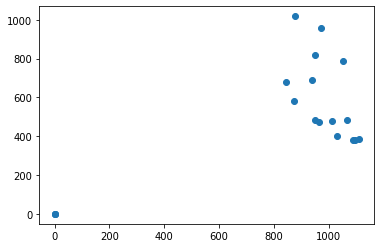

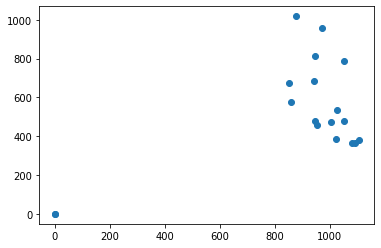

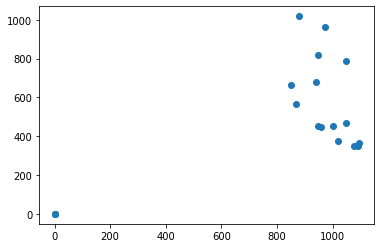

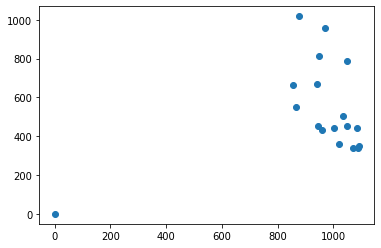

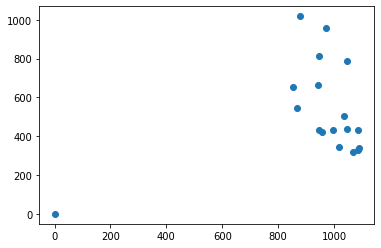

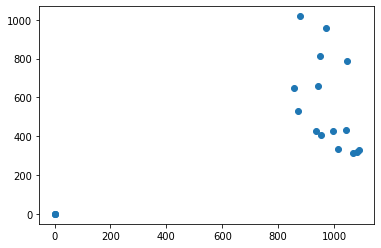

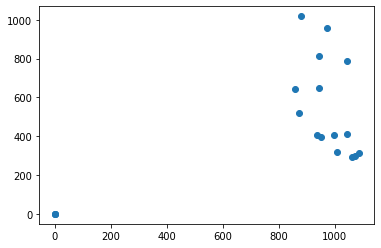

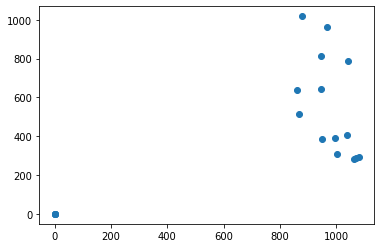

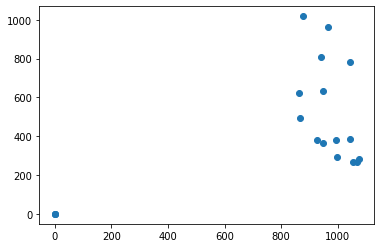

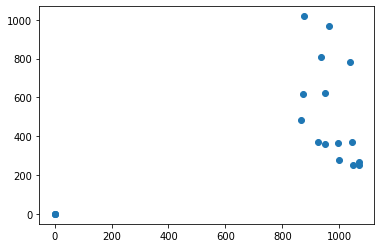

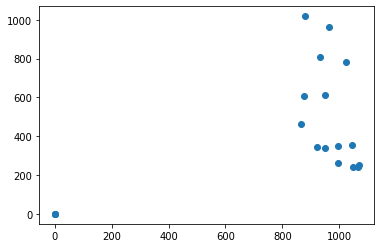

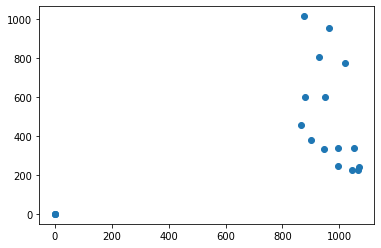

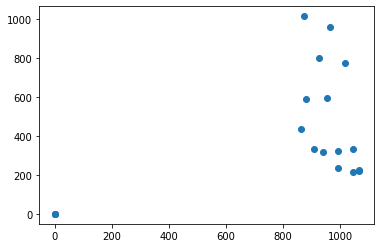

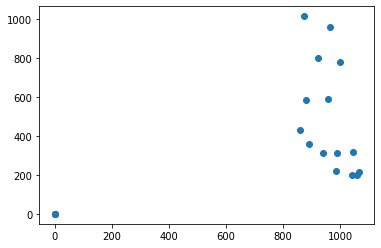

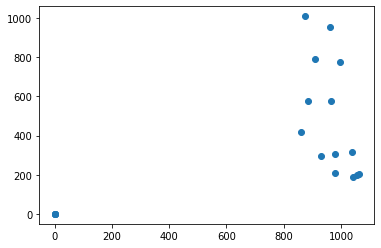

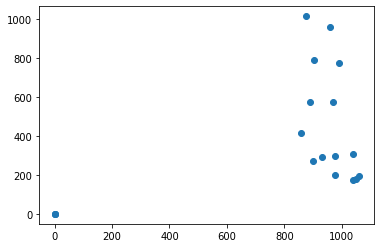

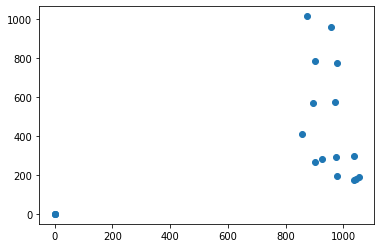

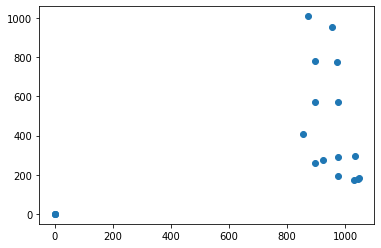

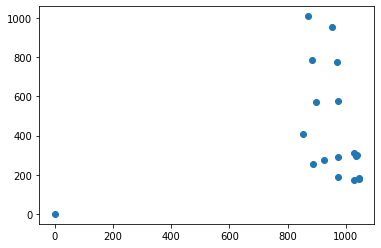

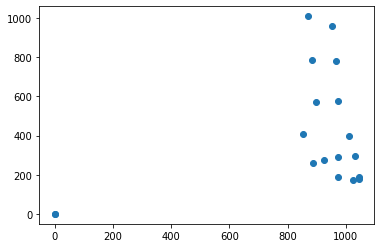

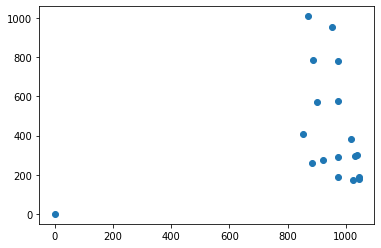

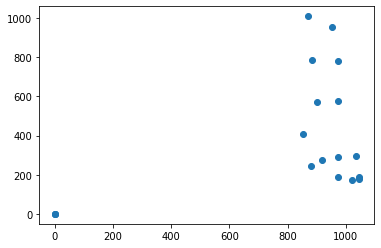

<Figure size 432x288 with 0 Axes>

In [104]:
orig_person = X[0]

for k in range(len(orig_person)):
    xso=[]
    yso=[]
    for i in range(0,18):
        xso = xso + [orig_person[k][2*i]]
        yso = yso + [orig_person[k][2*i+1]]
    plt.scatter(xso,yso)
    plt.pause(1)
    plt.clf() # clear the previous plot
    
    
    



36


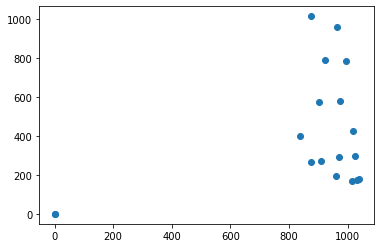

36


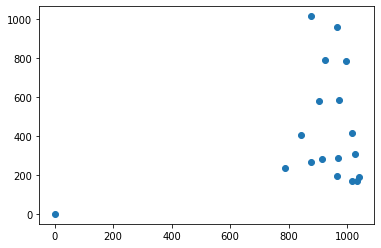

36


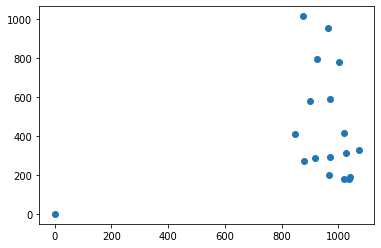

36


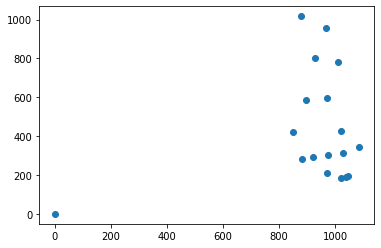

36


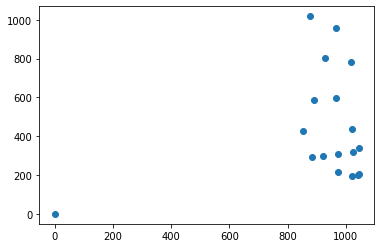

36


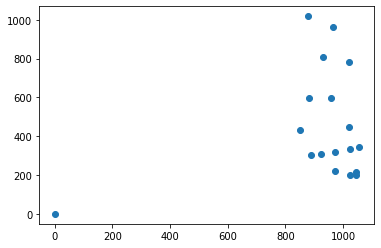

36


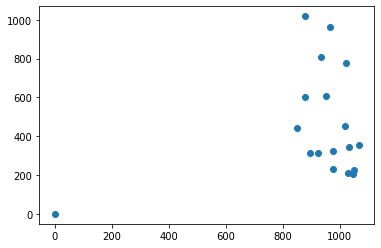

36


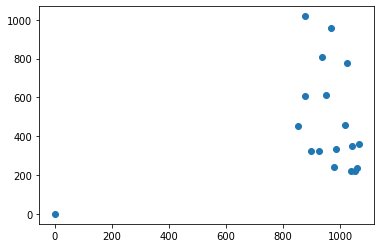

36


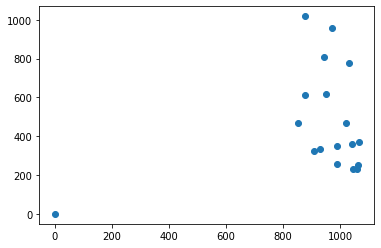

36


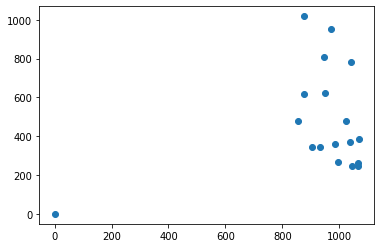

36


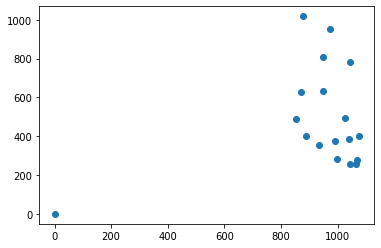

36


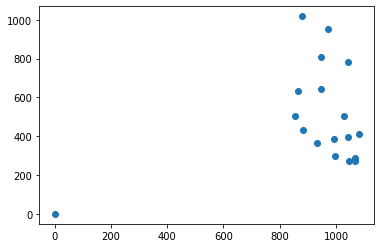

36


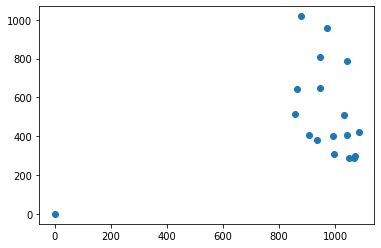

36


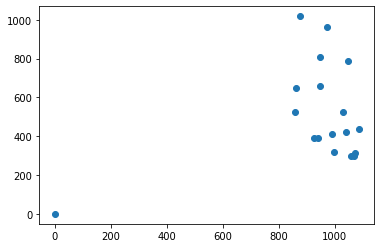

36


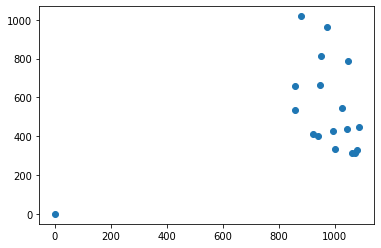

36


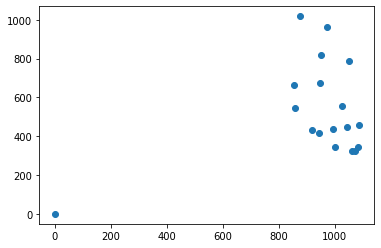

36


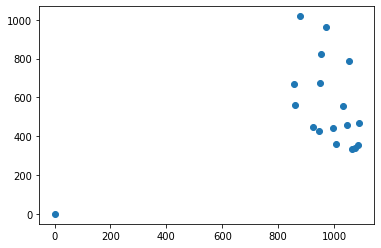

36


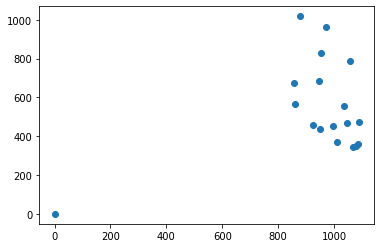

36


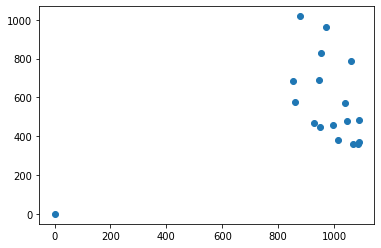

36


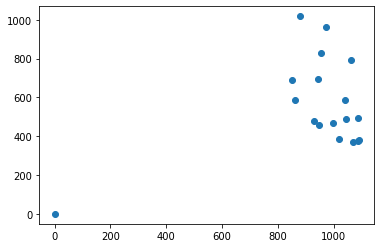

36


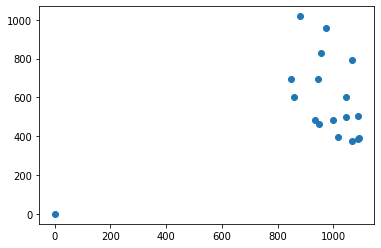

36


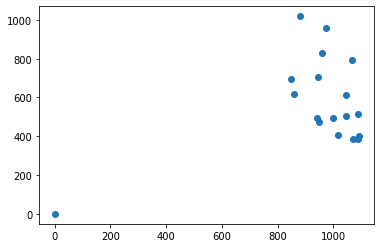

36


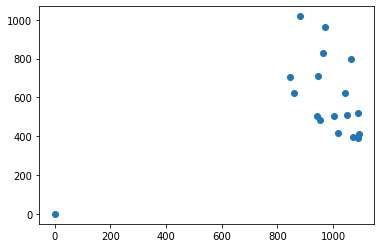

36


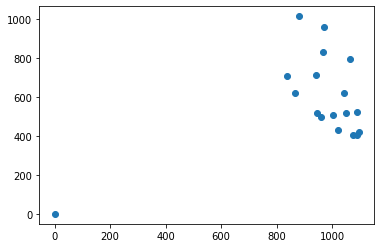

36


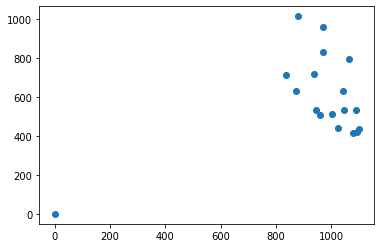

36


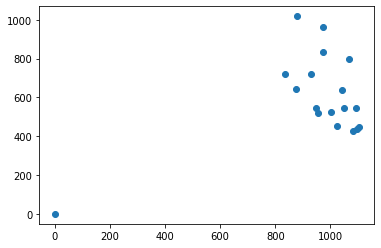

36


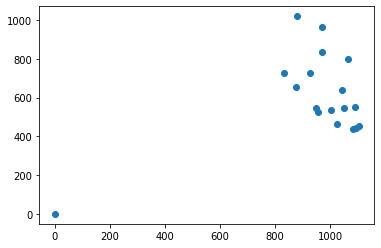

36


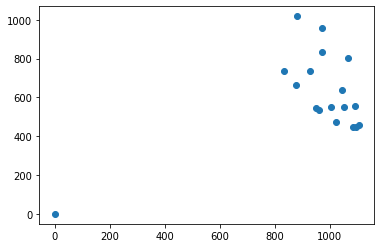

36


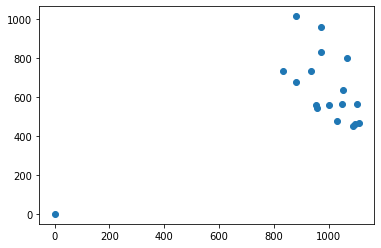

36


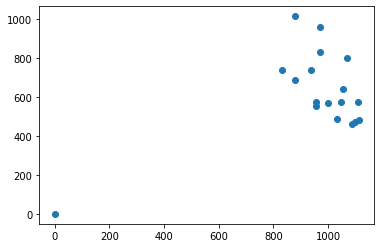

36


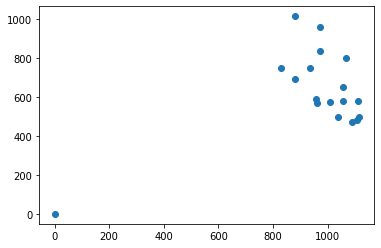

36


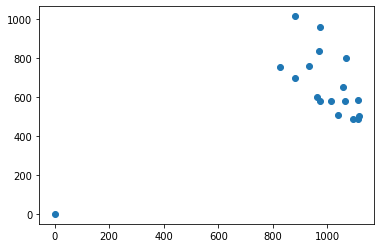

36


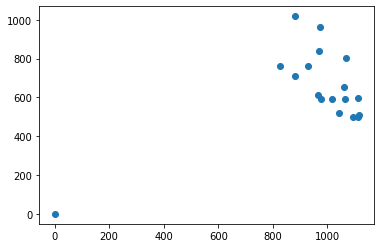

36


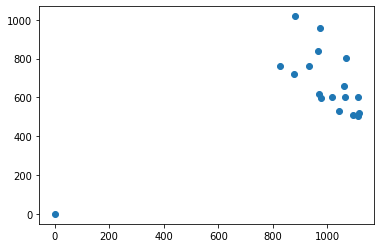

36


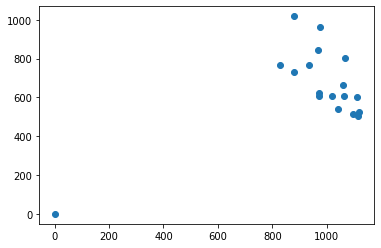

36


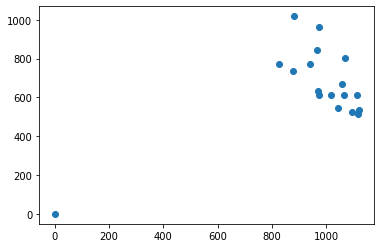

36


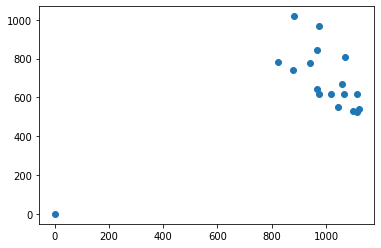

36


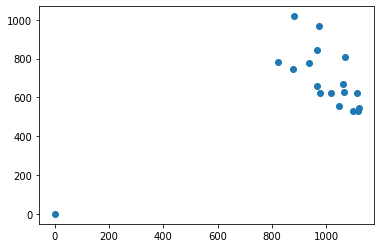

36


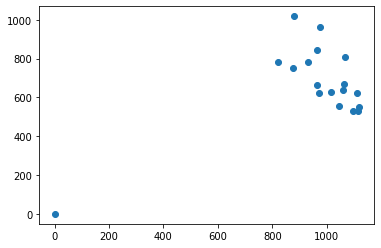

36


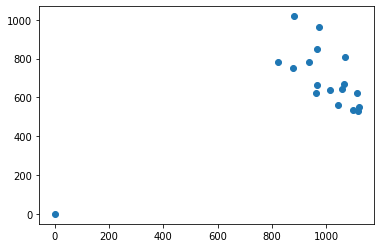

36


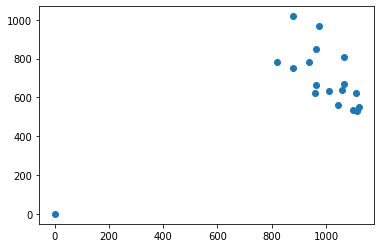

36


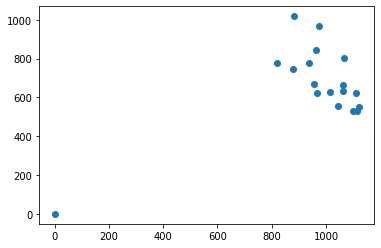

36


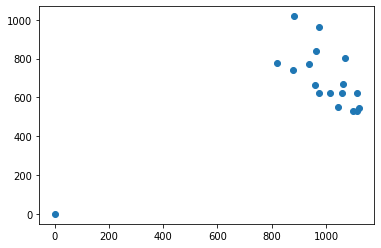

36


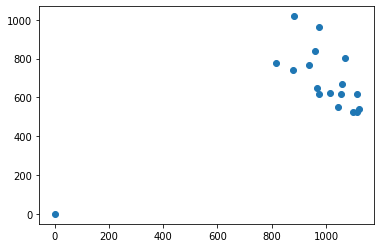

36


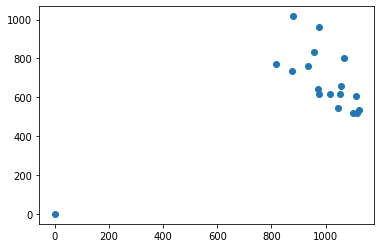

36


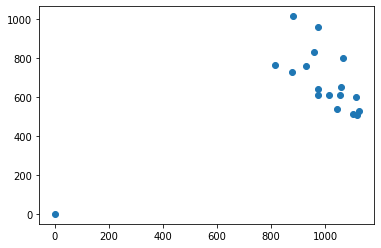

36


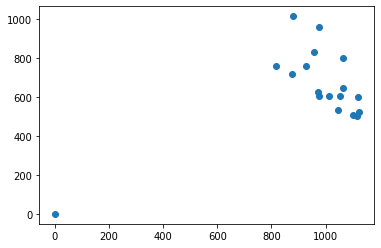

36


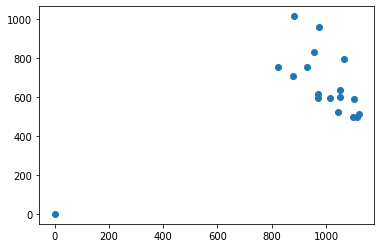

36


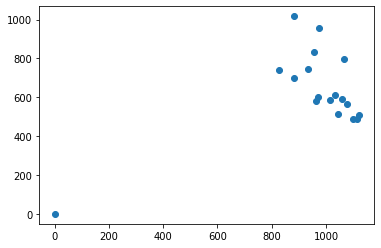

36


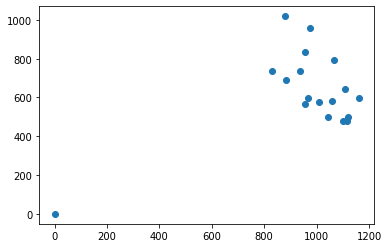

36


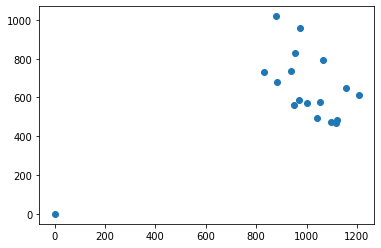

36


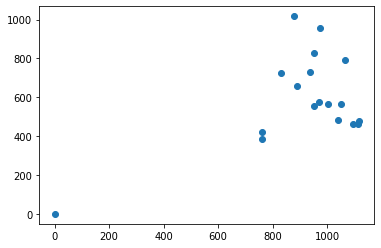

36


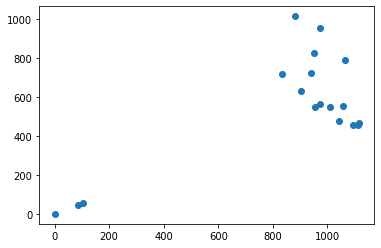

36


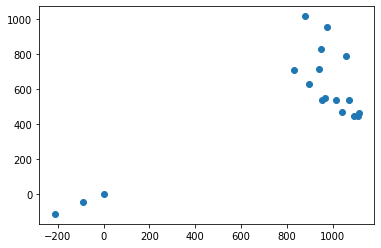

36


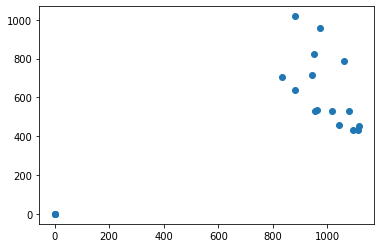

36


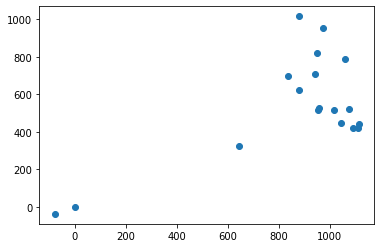

36


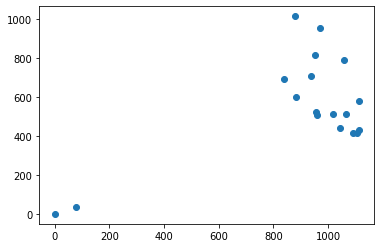

36


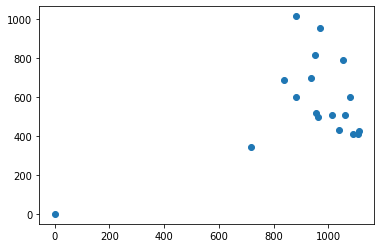

36


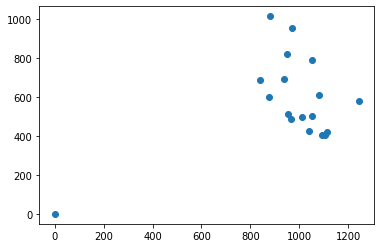

36


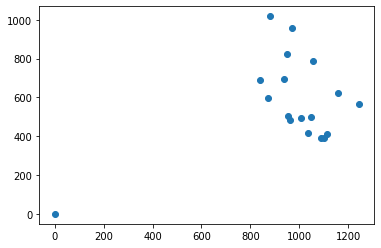

36


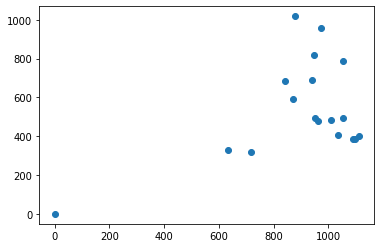

36


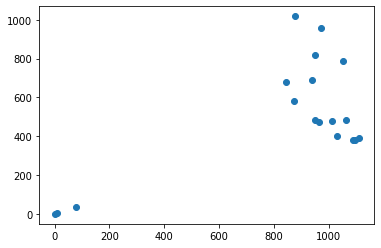

36


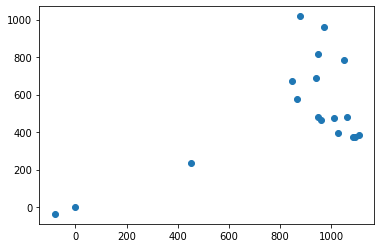

36


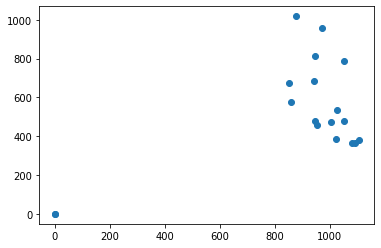

36


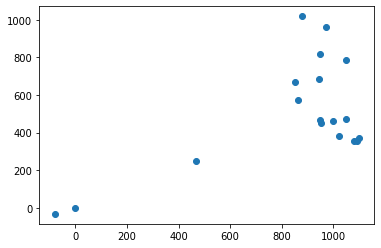

36


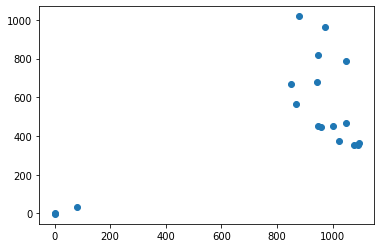

36


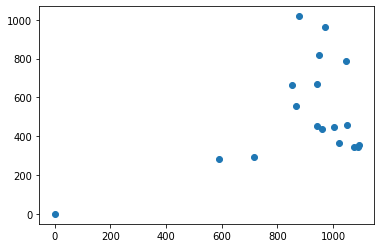

36


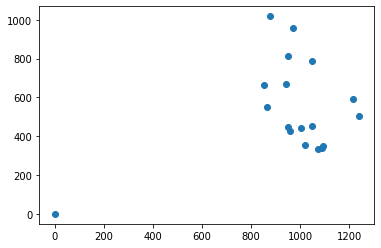

36


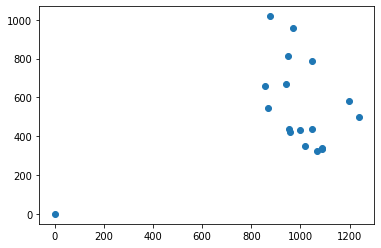

36


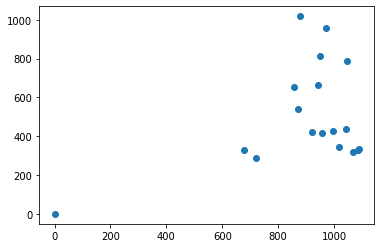

36


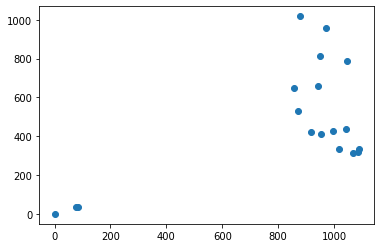

36


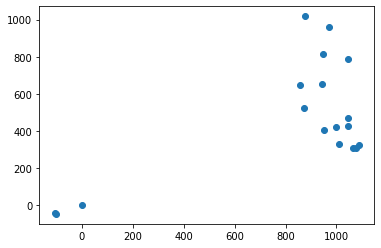

36


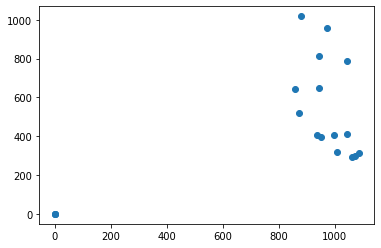

36


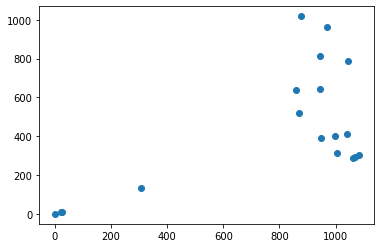

36


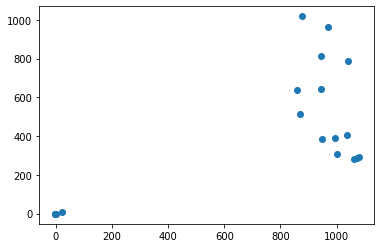

36


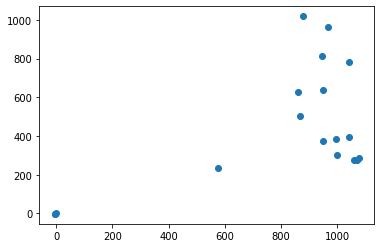

36


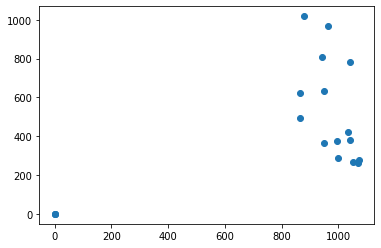

36


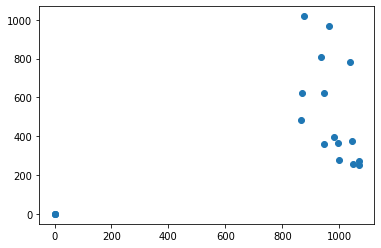

36


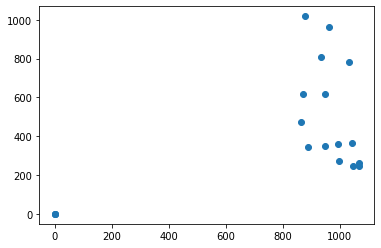

36


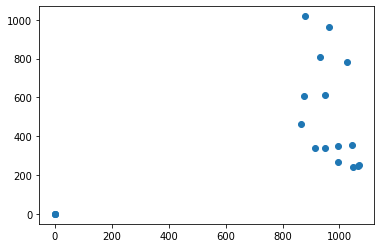

36


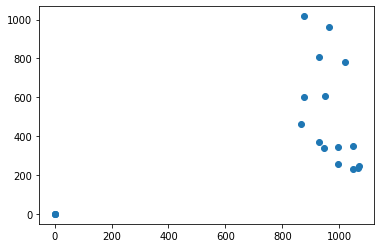

36


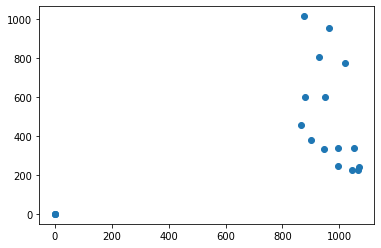

36


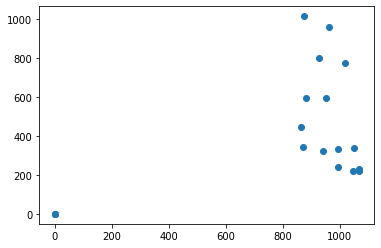

36


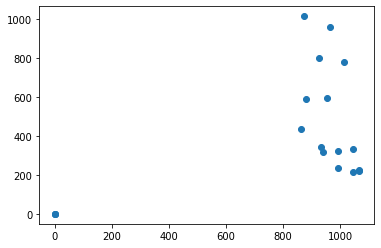

36


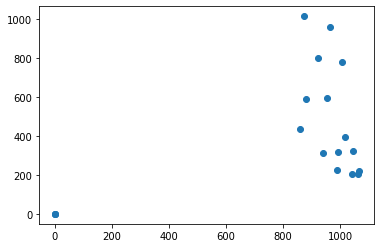

36


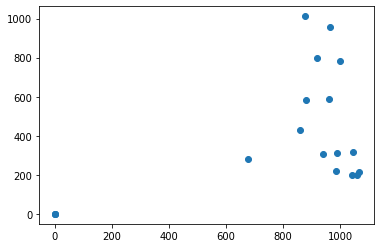

36


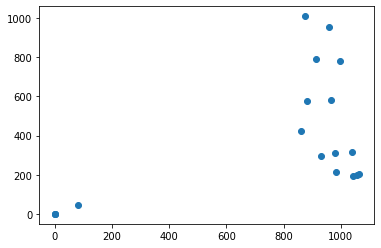

36


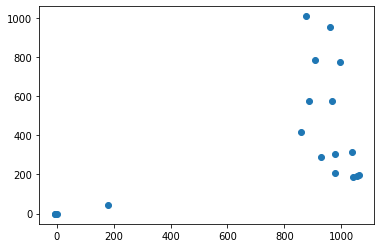

36


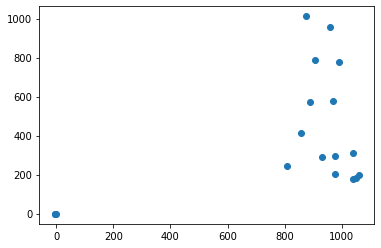

36


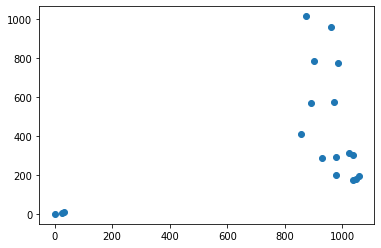

36


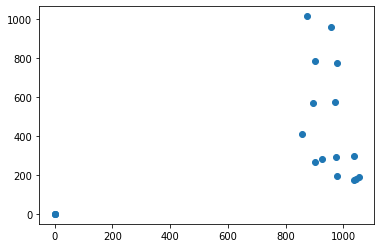

36


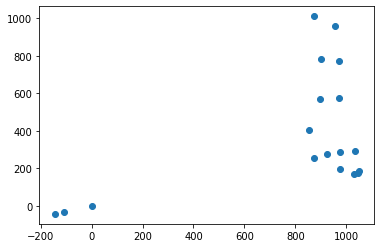

36


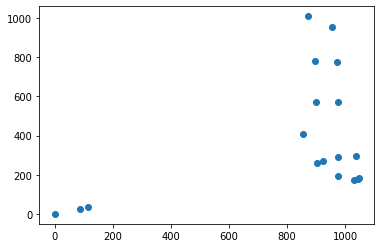

36


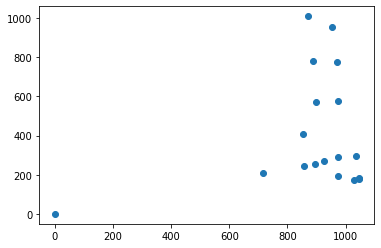

36


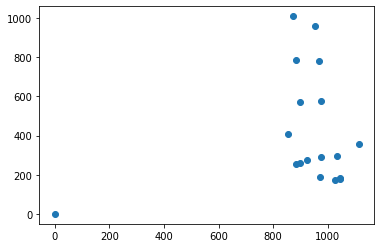

36


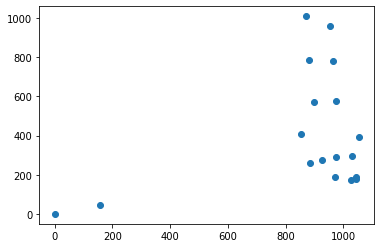

36


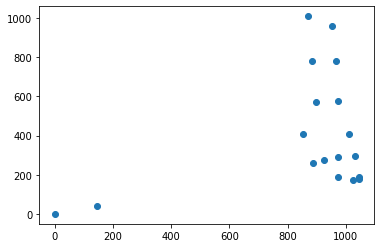

36


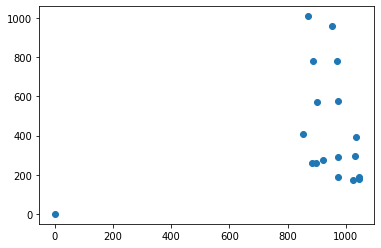

36


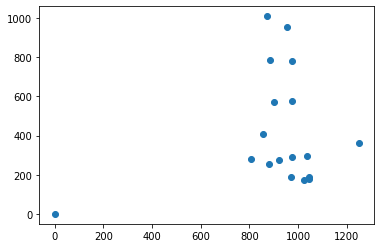

36


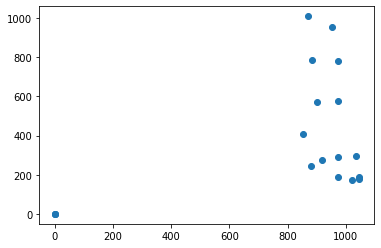

<Figure size 432x288 with 0 Axes>

In [114]:
interp_person = interpolated_frames[0]

for k in range(100):
    
    seq = interp_person[36*k : 36*(k+1)]
    xso=[]
    yso=[]
    for i in range(0,18):
        xso = xso + [seq[2*i]]
        yso = yso + [seq[2*i+1]]
    plt.scatter(xso,yso)
    plt.pause(1)
    plt.clf() # clear the previous plot

In [59]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.svm import SVC

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

In [55]:
svc = SVC(C=30)


cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=0)
cross_val_score(svc, X_t, y, cv=cv)

array([0.83333333, 0.9       , 0.96666667])

In [231]:
svc.fit(X_train,y_train)

print(svc.score(X_test,y_test))

0.8833333333333333


### Decision Tree classifier 

In [56]:
from sklearn.tree import DecisionTreeClassifier as DTC

In [129]:
dtc = DTC(max_depth=17,random_state=42,max_leaf_nodes=30)

In [130]:
dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=17, max_leaf_nodes=30, random_state=42)

In [131]:
dtc.score(X_test,y_test)

0.6833333333333333

In [132]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [182]:
rfc = RFC(40,criterion = 'entropy',max_depth=40,random_state=40)

In [183]:
rfc.fit(X_train,y_train)
rfc.score(X_test,y_test)

0.8166666666666667

In [185]:
from sklearn.neighbors import KNeighborsClassifier as KNC


In [229]:
knc = KNC(3,weights='distance',p=1)

In [230]:
knc.fit(X_train,y_train)


KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

In [231]:
knc.score(X_test,y_test)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4ca18598b0>
Traceback (most recent call last):
  File "/home/tudor/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/tudor/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/tudor/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/tudor/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


0.8

In [235]:
cross_val_score(rfc, X_t, y, cv=cv)

array([0.8       , 0.9       , 0.86666667])

## Support Vector Machine


In [252]:
svc = SVC(C=30)

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=0)
cross_val_score(svc, X_t, y, cv=cv)

array([0.83333333, 0.9       , 0.96666667])

In [253]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [254]:
C = np.arange(0,100)
kernel =['linear', 'poly', 'rbf', 'sigmoid'] 
parameters = {'C':C, 'kernel':kernel}

In [255]:
clf = RandomizedSearchCV(svc, parameters, scoring='accuracy', n_iter=100, cv=3, verbose=2)

clf.fit(X_train,y_train)



Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...................................C=15, kernel=rbf; total time=   0.0s
[CV] END ...................................C=15, kernel=rbf; total time=   0.0s
[CV] END ...................................C=15, kernel=rbf; total time=   0.0s
[CV] END ..................................C=16, kernel=poly; total time=   0.0s
[CV] END ..................................C=16, kernel=poly; total time=   0.0s
[CV] END ..................................C=16, kernel=poly; total time=   0.0s
[CV] END ...................................C=97, kernel=rbf; total time=   0.0s
[CV] END ...................................C=97, kernel=rbf; total time=   0.0s
[CV] END ...................................C=97, kernel=rbf; total time=   0.0s
[CV] END ..................................C=76, kernel=poly; total time=   0.0s
[CV] END ..................................C=76, kernel=poly; total time=   0.0s
[CV] END ..................................C=7

[CV] END ...............................C=77, kernel=sigmoid; total time=   0.0s
[CV] END ...............................C=77, kernel=sigmoid; total time=   0.0s
[CV] END ...............................C=77, kernel=sigmoid; total time=   0.0s
[CV] END ...............................C=56, kernel=sigmoid; total time=   0.0s
[CV] END ...............................C=56, kernel=sigmoid; total time=   0.0s
[CV] END ...............................C=56, kernel=sigmoid; total time=   0.0s
[CV] END ...............................C=90, kernel=sigmoid; total time=   0.0s
[CV] END ...............................C=90, kernel=sigmoid; total time=   0.0s
[CV] END ...............................C=90, kernel=sigmoid; total time=   0.0s
[CV] END ...............................C=95, kernel=sigmoid; total time=   0.0s
[CV] END ...............................C=95, kernel=sigmoid; total time=   0.0s
[CV] END ...............................C=95, kernel=sigmoid; total time=   0.0s
[CV] END ...................

[CV] END .................................C=3, kernel=linear; total time=   0.0s
[CV] END .................................C=3, kernel=linear; total time=   0.0s
[CV] END .................................C=3, kernel=linear; total time=   0.0s
[CV] END ..................................C=62, kernel=poly; total time=   0.0s
[CV] END ..................................C=62, kernel=poly; total time=   0.0s
[CV] END ..................................C=62, kernel=poly; total time=   0.0s
[CV] END ...................................C=62, kernel=rbf; total time=   0.0s
[CV] END ...................................C=62, kernel=rbf; total time=   0.0s
[CV] END ...................................C=62, kernel=rbf; total time=   0.0s
[CV] END ...............................C=84, kernel=sigmoid; total time=   0.0s
[CV] END ...............................C=84, kernel=sigmoid; total time=   0.0s
[CV] END ...............................C=84, kernel=sigmoid; total time=   0.0s
[CV] END ...................

RandomizedSearchCV(cv=3, estimator=SVC(C=30), n_iter=100,
                   param_distributions={'C': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   scoring='accuracy', verbose=2)

In [256]:
clf.best_params_

{'kernel': 'rbf', 'C': 87}

In [257]:
svcu = SVC(C=87,kernel = 'rbf')

In [269]:
cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=0)
cross_val_score(svcu, X_t, y, cv=cv)

array([0.83333333, 0.9       , 0.96666667])

In [268]:
svcu.fit(X_train,y_train)
svcu.score(X_test,y_test)

0.8666666666666667

## Decision Tree

In [293]:
dtc = DTC(max_depth=17,random_state=42,max_leaf_nodes=30)

dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=17, max_leaf_nodes=30, random_state=42)

In [294]:
dtc.score(X_test,y_test)

0.6833333333333333

In [284]:
criterion = ['gini','entropy', 'log_loss']

max_depth = np.arange(10,100)
max_leaf_nodes = np.arange(10,100)
random_state = np.arange(0,100)

In [295]:
params = {'max_depth':max_depth, 'max_leaf_nodes':max_leaf_nodes,'random_state':random_state}

clff = RandomizedSearchCV(dtc, params, scoring='accuracy', n_iter=100, cv=3, verbose=2)

clff.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=93, max_leaf_nodes=53, random_state=37; total time=   0.0s
[CV] END ...max_depth=93, max_leaf_nodes=53, random_state=37; total time=   0.0s
[CV] END ...max_depth=93, max_leaf_nodes=53, random_state=37; total time=   0.0s
[CV] END ...max_depth=22, max_leaf_nodes=52, random_state=50; total time=   0.0s
[CV] END ...max_depth=22, max_leaf_nodes=52, random_state=50; total time=   0.0s
[CV] END ...max_depth=22, max_leaf_nodes=52, random_state=50; total time=   0.0s
[CV] END ...max_depth=67, max_leaf_nodes=87, random_state=28; total time=   0.0s
[CV] END ...max_depth=67, max_leaf_nodes=87, random_state=28; total time=   0.0s
[CV] END ...max_depth=67, max_leaf_nodes=87, random_state=28; total time=   0.0s
[CV] END ...max_depth=96, max_leaf_nodes=36, random_state=13; total time=   0.0s
[CV] END ...max_depth=96, max_leaf_nodes=36, random_state=13; total time=   0.0s
[CV] END ...max_depth=96, max_leaf_nodes=36, r

[CV] END ...max_depth=14, max_leaf_nodes=49, random_state=71; total time=   0.0s
[CV] END ...max_depth=14, max_leaf_nodes=49, random_state=71; total time=   0.0s
[CV] END ...max_depth=14, max_leaf_nodes=49, random_state=71; total time=   0.0s
[CV] END ...max_depth=79, max_leaf_nodes=89, random_state=90; total time=   0.0s
[CV] END ...max_depth=79, max_leaf_nodes=89, random_state=90; total time=   0.0s
[CV] END ...max_depth=79, max_leaf_nodes=89, random_state=90; total time=   0.0s
[CV] END ...max_depth=39, max_leaf_nodes=14, random_state=79; total time=   0.0s
[CV] END ...max_depth=39, max_leaf_nodes=14, random_state=79; total time=   0.0s
[CV] END ...max_depth=39, max_leaf_nodes=14, random_state=79; total time=   0.0s
[CV] END ...max_depth=69, max_leaf_nodes=31, random_state=63; total time=   0.0s
[CV] END ...max_depth=69, max_leaf_nodes=31, random_state=63; total time=   0.0s
[CV] END ...max_depth=69, max_leaf_nodes=31, random_state=63; total time=   0.0s
[CV] END ...max_depth=11, ma

[CV] END ...max_depth=46, max_leaf_nodes=35, random_state=60; total time=   0.0s
[CV] END ...max_depth=46, max_leaf_nodes=35, random_state=60; total time=   0.0s
[CV] END ...max_depth=61, max_leaf_nodes=21, random_state=15; total time=   0.0s
[CV] END ...max_depth=61, max_leaf_nodes=21, random_state=15; total time=   0.0s
[CV] END ...max_depth=61, max_leaf_nodes=21, random_state=15; total time=   0.0s
[CV] END ...max_depth=44, max_leaf_nodes=51, random_state=48; total time=   0.0s
[CV] END ...max_depth=44, max_leaf_nodes=51, random_state=48; total time=   0.0s
[CV] END ...max_depth=44, max_leaf_nodes=51, random_state=48; total time=   0.0s
[CV] END ...max_depth=46, max_leaf_nodes=39, random_state=66; total time=   0.0s
[CV] END ...max_depth=46, max_leaf_nodes=39, random_state=66; total time=   0.0s
[CV] END ...max_depth=46, max_leaf_nodes=39, random_state=66; total time=   0.0s
[CV] END ...max_depth=76, max_leaf_nodes=53, random_state=66; total time=   0.0s
[CV] END ...max_depth=76, ma

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(max_depth=17,
                                                    max_leaf_nodes=30,
                                                    random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74...
       95, 96, 97, 98, 99]),
                                        'random_state': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   scoring='accuracy', verbose=2)

In [296]:
clff.best_params_

{'random_state': 45, 'max_leaf_nodes': 93, 'max_depth': 42}

In [300]:
dtcu = DTC(max_depth=42,random_state=45,max_leaf_nodes=93)

In [301]:
dtcu.fit(X_train,y_train)
dtcu.score(X_test,y_test)

0.65

In [302]:
cross_val_score(dtcu, X_t, y, cv=cv)

array([0.56666667, 0.83333333, 0.83333333])